<a href="https://colab.research.google.com/github/tnwlvos/machinelearning2/blob/main/TermProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [256]:
import tensorflow as tf
import numpy as np

def positional_encoding(position, d_model):
     # 각 위치(pos)와 차원(d_model)에 대해 angle 값을 계산하기 위한 기반 배열 생성
    angle_rads = np.arange(position)[:, np.newaxis] / np.power(
        10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model)
    )

    # 짝수 인덱스 차원에는 sin을 적용
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    # 홀수 인덱스 차원에는 cos을 적용
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    # (1, position, d_model) 형태로 리턴 (batch에 브로드캐스팅 가능)
    return tf.cast(angle_rads[np.newaxis, ...], dtype=tf.float32)

In [257]:
class EncoderLayer(tf.keras.layers.Layer):
   def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()
     # Multi-Head Attention (Self Attention)
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads)

        # FFN (Position-wise Feed Forward Network)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),  # 확장
            tf.keras.layers.Dense(d_model)                 # 원래 차원으로 복귀
        ])

        # Residual + LayerNorm
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        # Dropout (overfitting 방지)
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)

   def call(self, x, training=None):
        # Self-Attention 계산 (Query=Key=Value=x)
        attn_output = self.mha(x, x)

        # Dropout 적용
        attn_output = self.dropout1(attn_output, training=training)

        # Residual connection + LayerNorm
        out1 = self.layernorm1(x + attn_output)

        # FFN 통과
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)

        # Residual connection + LayerNorm
        out2 = self.layernorm2(out1 + ffn_output)

        return out2


In [258]:
def build_transformer(window, input_features,output_features, horizon,
                      num_layers=4, d_model=64, num_heads=4, dff=128, dropout_rate=0.1):


    # 입력: (batch, window 길이, feature 개수)
    inputs = tf.keras.Input(shape=(window,input_features))

    # 입력 feature를 d_model 차원으로 projection (임베딩 역할)
    x = tf.keras.layers.Dense(d_model)(inputs)

    # Positional Encoding 생성
    pos_encoding = positional_encoding(window, d_model)

    # 입력 embedding + positional encoding (순서 정보 부여)
    x = x + pos_encoding

    # Encoder layer 여러 개 반복
    for _ in range(num_layers):
        x = EncoderLayer(d_model, num_heads, dff, dropout_rate)(x)

    # # 시계열 전체를 요약하기 위해 Global Average Pooling 적용
    # x = tf.keras.layers.GlobalAveragePooling1D()(x)
    # x = tf.keras.layers.Dense(256, activation='relu')(x)
    # x = tf.keras.layers.Dropout(0.1)(x)

    # x= RepeatVector(horizon)(x)  # (batch, horizon, 128)

    # x = LSTM(128, return_sequences=True)(x)  # (batch, horizon, 128)
    # outputs = TimeDistributed(tf.keras.layers.Dense(output_features))(x)
    x = Conv1D(128, 3, padding='causal', activation='relu')(x)
    x = LSTM(128)(x)     # ✨ 마지막 state만 사용 → horizon 예측 가능
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.1)(x)

    x = Dense(horizon * output_features)(x)
    outputs = Reshape((horizon, output_features))(x)
    # 모델 구성 완료
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Optimizer + Loss 설정
    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.0001),
        loss='mse'
    )

    return model

In [259]:
def make_transformer_traindata(df,window,horizon):
  raw = df[['Open','High','Low','Close','Volume','MACD','MACD_signal','MACD_hist']].values.astype(np.float32)
  X = []
  Y = []

  for i in range(len(raw) - window - horizon):
      X.append(raw[i : i + window])                       # (window, F)
      Y.append(raw[i + window : i + window + horizon, :4]) # open,high,low,close의  horizon일 예측

  X = np.array(X)   # (N, window, F)
  Y = np.array(Y)   # (N, horizon)
  return X , Y





In [260]:
def make_transformer_testdata(train_df, test_df, window, horizon):
    # OHLCV만 선택
    train_raw = train_df[['Open','High','Low','Close','Volume','MACD','MACD_signal','MACD_hist']].values.astype(np.float32)
    test_raw  = test_df[['Open','High','Low','Close','Volume','MACD','MACD_signal','MACD_hist']].values.astype(np.float32)

    # train 마지막 window일
    prefix = train_raw[-window:]    # shape (window, F)

    # prefix + test를 연결
    full_test_raw = np.vstack([prefix, test_raw])

    total_len = len(full_test_raw)
    if total_len < window + horizon:
        # 이 경우엔 테스트 윈도우 자체가 불가능하니까, 명시적으로 에러 내는 게 좋음
        raise ValueError(
            f"❌ Not enough test data: need at least {window + horizon}, got {total_len}"
        )
    # 슬라이딩 윈도우 적용 (train과 동일하게)

    X, Y = [], []

    for i in range(len(full_test_raw) - window - horizon):
        X.append(full_test_raw[i : i + window])
        Y.append(full_test_raw[i + window : i + window + horizon, :4])

    return np.array(X), np.array(Y)

In [261]:
#데이터 정규화
def standard_fit(train_df):
    scaler = StandardScaler()
    scaler.fit(train_df)      # train 데이터로만 학습
    return scaler

def standard_transform(scaler, df):
    df_scaled = scaler.transform(df)
    return pd.DataFrame(df_scaled, columns=df.columns, index=df.index)

def standard_inverse(scaler, df_scaled):
    df_inv = scaler.inverse_transform(df_scaled)
    return pd.DataFrame(df_inv, columns=df_scaled.columns, index=df_scaled.index)

In [262]:
def Normalization(train_df, test_df):
  # 1) scaler 학습 (train에서만)
  scaler = standard_fit(train_df)

  # 2) transform
  train_scaled = standard_transform(scaler, train_df)
  test_scaled  = standard_transform(scaler, test_df)
  return train_scaled,test_scaled, scaler



In [263]:
def add_macd(df):
    # EMA 계산
    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=26, adjust=False).mean()

    # MACD 라인
    macd = ema12 - ema26

    # 시그널 라인
    signal = macd.ewm(span=9, adjust=False).mean()

    # 히스토그램
    hist = macd - signal

    df['MACD'] = macd
    df['MACD_signal'] = signal
    df['MACD_hist'] = hist

    return df


In [264]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense,Dropout,Reshape,RepeatVector, LSTM, TimeDistributed, Conv1D, GlobalMaxPooling1D
window = 12  # 과거 30개 보고
horizon = 4   # 미래 4개 예측
# data load
shinpoong_pharm_finance = yf.download('019170.KS', start='2014-12-01') # 신풍제약의 작은 폭의 잦은 등락으로 상승 추세선의 2015 부근이라  2014-12부터 선택
robostar_finance = yf.download('090360.KQ', start='2013-09-01')        # 로보스타의 작은 하락 추세선을 학습에 사용하기 위함
daihan_pharm_finance = yf.download('023910.KQ', start='2010-09-01')    # 급등 전의 신호가 있는 위치가 2010-09
dbhitek_finance = yf.download('000990.KS', start='2009-05-01')         # 등락 변동성이 가장 큰 부분부터 시작하기 위함
skdnd_finance = yf.download('210980.KS', start='2016-05-01')           # 상장 후 안정기에 진입했을 때부터 학습
split_date = '2025-10-20'
#macd적
shinpoong_pharm_finance = add_macd(shinpoong_pharm_finance)
robostar_finance = add_macd(robostar_finance)
daihan_pharm_finance = add_macd(daihan_pharm_finance)
dbhitek_finance = add_macd(dbhitek_finance)
skdnd_finance = add_macd(skdnd_finance)

cols = ['Open','High','Low','Close','Volume','MACD','MACD_signal','MACD_hist']
shinpoong_pharm_finance = shinpoong_pharm_finance[cols].dropna()
robostar_finance  = robostar_finance[cols].dropna()
daihan_pharm_finance    = daihan_pharm_finance[cols].dropna()
dbhitek_finance  = dbhitek_finance[cols].dropna()
skdnd_finance   = skdnd_finance[cols].dropna()
#train_test 나누기
shinpoong_train = shinpoong_pharm_finance[shinpoong_pharm_finance.index < split_date]
shinpoong_test  = shinpoong_pharm_finance[shinpoong_pharm_finance.index >= split_date]

robostar_train = robostar_finance[robostar_finance.index < split_date]
robostar_test  = robostar_finance[robostar_finance.index >= split_date]

daihan_train = daihan_pharm_finance[daihan_pharm_finance.index < split_date]
daihan_test= daihan_pharm_finance[daihan_pharm_finance.index >= split_date]

dbhitek_train=dbhitek_finance[dbhitek_finance.index < split_date]
dbhitek_test=dbhitek_finance[dbhitek_finance.index >= split_date]

skdnd_train=skdnd_finance[skdnd_finance.index < split_date]
skdnd_test=skdnd_finance[skdnd_finance.index >= split_date]

# 신풍
shinpoong_train, shinpoong_test, shinpoong_scaler = Normalization(
    shinpoong_train, shinpoong_test
)

# 대화
daihan_train, daihan_test, daihan_scaler = Normalization(
    daihan_train, daihan_test
)

# DB하이텍
dbhitek_train, dbhitek_test, dbhitek_scaler = Normalization(
    dbhitek_train, dbhitek_test
)

# 로보스타
robostar_train, robostar_test, robostar_scaler = Normalization(
    robostar_train, robostar_test
)

# SK디앤디
skdnd_train, skdnd_test, skdnd_scaler = Normalization(
    skdnd_train, skdnd_test
)





#x,y데이터 (transformer용으로 생성)
shinpoong_train_x,shinpoong_train_y=make_transformer_traindata(shinpoong_train,window,horizon)
shinpoong_test_x,shinpoong_test_y=make_transformer_testdata(shinpoong_train,shinpoong_test,window,horizon)

full_index = list(shinpoong_train.index[-window:]) + list(shinpoong_test.index)
full_index = pd.to_datetime(full_index)

robostar_train_x,robostar_train_y=make_transformer_traindata(robostar_train,window,horizon)
robostar_test_x,robostar_test_y=make_transformer_testdata(robostar_train,robostar_test,window,horizon)

daihan_train_x,daihan_train_y=make_transformer_traindata(daihan_train,window,horizon)
daihan_test_x,daihan_test_y=make_transformer_testdata(daihan_train,daihan_test,window,horizon)

dbhitek_train_x,dbhitek_train_y=make_transformer_traindata(dbhitek_train,window,horizon)
dbhitek_test_x,dbhitek_test_y=make_transformer_testdata(dbhitek_train,dbhitek_test,window,horizon)

skdnd_train_x,skdnd_train_y=make_transformer_traindata(skdnd_train,window,horizon)
skdnd_test_x,skdnd_test_y=make_transformer_testdata(skdnd_train,skdnd_test,window,horizon)

print("X shape:", shinpoong_train_x.shape)
print("Y shape:", shinpoong_train_y.shape)
print("X[0]:\n", shinpoong_train_x[0])
print("X[0] shape:", shinpoong_train_x[0].shape)

print("\nY[0]:\n", shinpoong_train_y[0])
print("Y[0] shape:", shinpoong_train_y[0].shape)

print("X shape:", shinpoong_test_x.shape)
print("Y shape:", shinpoong_test_y.shape)
print("X[0]:\n", shinpoong_test_x[0])
print("X[0] shape:", shinpoong_test_x[0].shape)

print("\nY[0]:\n", shinpoong_test_y[0])
print("Y[0] shape:", shinpoong_test_y[0].shape)

input_features =8
output_features=4





/tmp/ipython-input-285297051.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  shinpoong_pharm_finance = yf.download('019170.KS', start='2014-12-01') # 신풍제약의 작은 폭의 잦은 등락으로 상승 추세선의 2015 부근이라  2014-12부터 선택
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-285297051.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  robostar_finance = yf.download('090360.KQ', start='2013-09-01')        # 로보스타의 작은 하락 추세선을 학습에 사용하기 위함
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-285297051.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  daihan_pharm_finance = yf.download('023910.KQ', start='2010-09-01')    # 급등 전의 신호가 있는 위치가 2010-09
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-285297051.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dbhi

X shape: (2650, 12, 8)
Y shape: (2650, 4, 4)
X[0]:
 [[-5.8064085e-01 -5.7374251e-01 -5.8706027e-01 -5.8234149e-01
  -2.8546682e-01 -8.3772531e-03 -9.0040416e-03 -7.0315094e-05]
 [-5.8438659e-01 -5.7641441e-01 -5.8755124e-01 -5.7936180e-01
  -2.9447743e-01 -5.7688174e-03 -8.4417472e-03  6.1824652e-03]
 [-5.7939231e-01 -5.7671130e-01 -5.8476907e-01 -5.8092999e-01
  -3.2694125e-01 -5.1277294e-03 -7.8537129e-03  6.4686849e-03]
 [-5.8001655e-01 -5.7789880e-01 -5.8836949e-01 -5.8155733e-01
  -3.2520831e-01 -5.2116429e-03 -7.4013746e-03  4.9597332e-03]
 [-5.8079696e-01 -5.7715660e-01 -5.8673292e-01 -5.8092999e-01
  -3.3026052e-01 -4.7643036e-03 -6.9430722e-03  5.0260569e-03]
 [-5.8157730e-01 -5.7493001e-01 -5.8722395e-01 -5.7732302e-01
  -2.9391390e-01 -1.2974310e-03 -5.8290833e-03  1.2317353e-02]
 [-5.7705122e-01 -5.7552379e-01 -5.8427817e-01 -5.7983226e-01
  -3.3621392e-01 -8.5849385e-04 -4.8432718e-03  1.0892012e-02]
 [-5.7908016e-01 -5.7745349e-01 -5.8493274e-01 -5.8014590e-01
  -3.397691

In [265]:
model = build_transformer(
    window=window,
    input_features=input_features,
    output_features=output_features,
    horizon=horizon,
    num_layers=2,
    d_model=64,
    num_heads=4,
    dff=128,
    dropout_rate=0.1
)

model.summary()

history = model.fit(
    shinpoong_train_x, shinpoong_train_y,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)


Model: "functional_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_64 (InputLayer)     │ (None, 12, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_146 (Dense)               │ (None, 12, 64)         │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ add_21 (Add)                    │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_layer_43 (EncoderLayer) │ (None, 12, 64)         │        33,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_layer_44 (EncoderLayer) │ (None, 12, 64)         │        33,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 12, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_151 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_150 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_152 (Dense)               │ (None, 16)             │         4,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_12 (Reshape)            │ (None, 4, 4)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 260,944 (1019.31 KB)

 Trainable params: 260,944 (1019.31 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.9192 - val_loss: 0.0196
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2288 - val_loss: 0.0082
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0810 - val_loss: 0.0132
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0527 - val_loss: 0.0198
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0469 - val_loss: 0.0107
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0406 - val_loss: 0.0058
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0418 - val_loss: 0.0105
Epoch 8/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0385 - val_loss: 0.0123
Epoch 9/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0373 - val_loss: 0.0055
Epoch 10/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0339 - val_loss: 0.0047
Epoch 11/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0332 - val_loss: 0.0059
Epoch 12/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
테스트 샘플 개수: 29


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52404 (\N{HANGUL SYLLABLE CE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/l

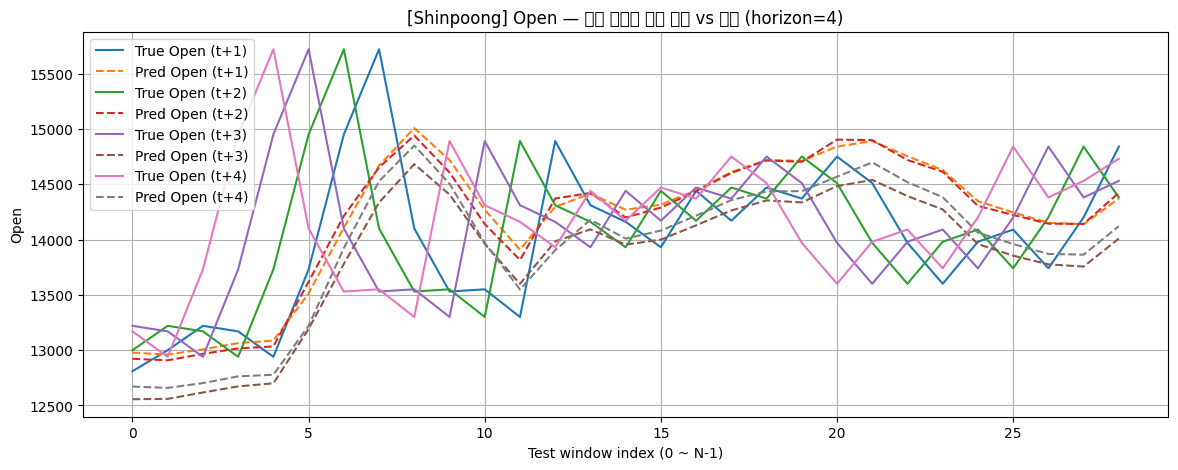

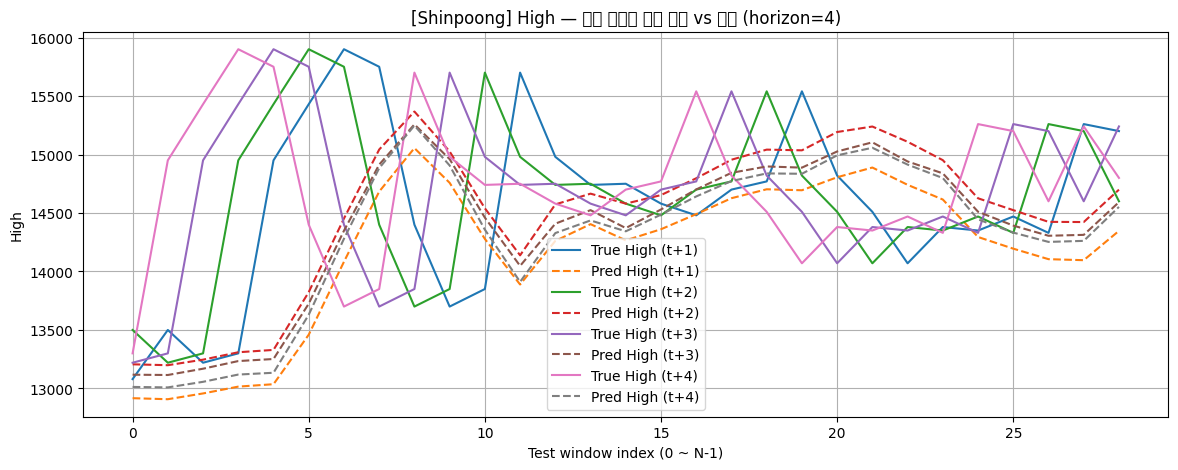

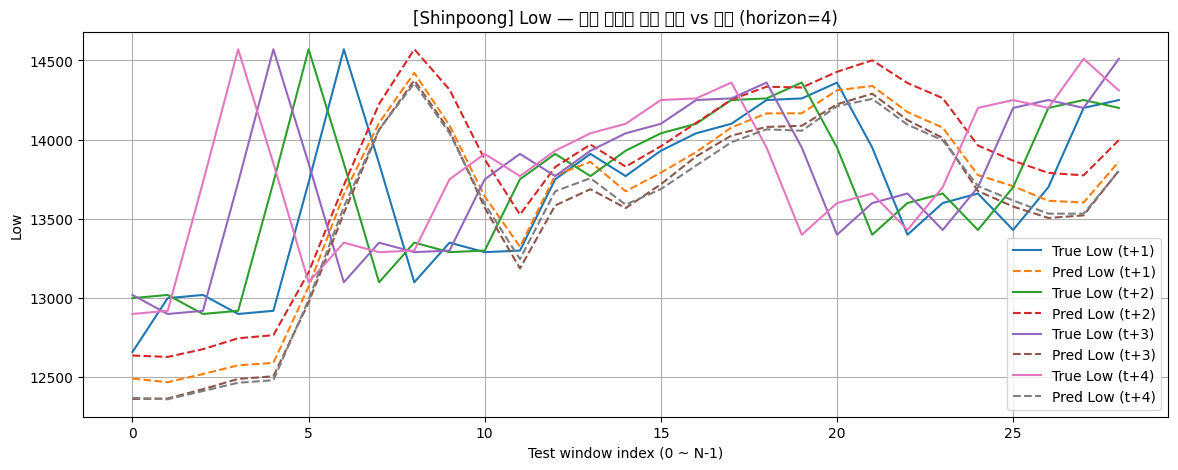

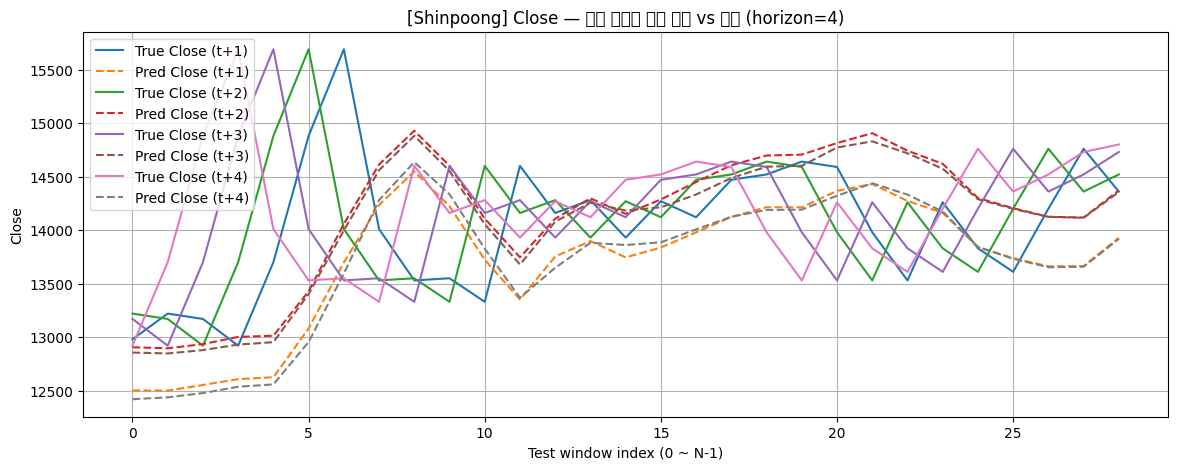

In [266]:
# ============================================
# 1) 전체 테스트 샘플에 대해 예측 수행
# ============================================
pred_test = model.predict(shinpoong_test_x)   # (N, horizon, 4)
true_test = shinpoong_test_y                  # (N, horizon, 4)

N = pred_test.shape[0]
h = horizon
F = 4   # OHLC

print("테스트 샘플 개수:", N)
# ============================================
# 2) 전체(모든 idx)에 대해 역정규화
#    - (N, h, 4) → (N*h, 4) → dummy Volume 추가 → inverse → 다시 (N, h, 4)
# ============================================

# (N, h, 4) -> (N*h, 4)
true_flat = true_test.reshape(-1, F)      # (N*h, 4)
pred_flat = pred_test.reshape(-1, F)      # (N*h, 4)

# dummy Volume 추가해서 (N*h, 5)로 만들기
dummy_vol_true = np.zeros((true_flat.shape[0], 4))
dummy_vol_pred = np.zeros((pred_flat.shape[0], 4))

true_full = np.hstack([true_flat, dummy_vol_true])   # (N*h, 5)
pred_full = np.hstack([pred_flat, dummy_vol_pred])   # (N*h, 5)

# 역정규화
true_inv_flat = shinpoong_scaler.inverse_transform(true_full)[:, :4]  # OHLC만 다시 사용
pred_inv_flat = shinpoong_scaler.inverse_transform(pred_full)[:, :4]

# 다시 (N, h, 4)로 reshape
true_inv = true_inv_flat.reshape(N, h, F)
pred_inv = pred_inv_flat.reshape(N, h, F)
# ============================================
# 3) 전체 idx에 대해 OHLC 예측 vs 실제 시각화
#    - x축: window 시작 기준 샘플 index (0 ~ N-1)
#    - y축: 가격
# ============================================

feature_names = ['Open', 'High', 'Low', 'Close']

for f_idx, fname in enumerate(feature_names):
    plt.figure(figsize=(14, 5))

    for step in range(h):
        # 각 horizon step에 대해 실제/예측 모두 그리기
        plt.plot(
            true_inv[:, step, f_idx],
            label=f'True {fname} (t+{step+1})'
        )
        plt.plot(
            pred_inv[:, step, f_idx],
            '--',
            label=f'Pred {fname} (t+{step+1})'
        )

    plt.title(f"[Shinpoong] {fname} — 전체 테스트 구간 예측 vs 실제 (horizon={h})")
    plt.xlabel("Test window index (0 ~ N-1)")
    plt.ylabel(fname)
    plt.legend()
    plt.grid(True)
    plt.show()


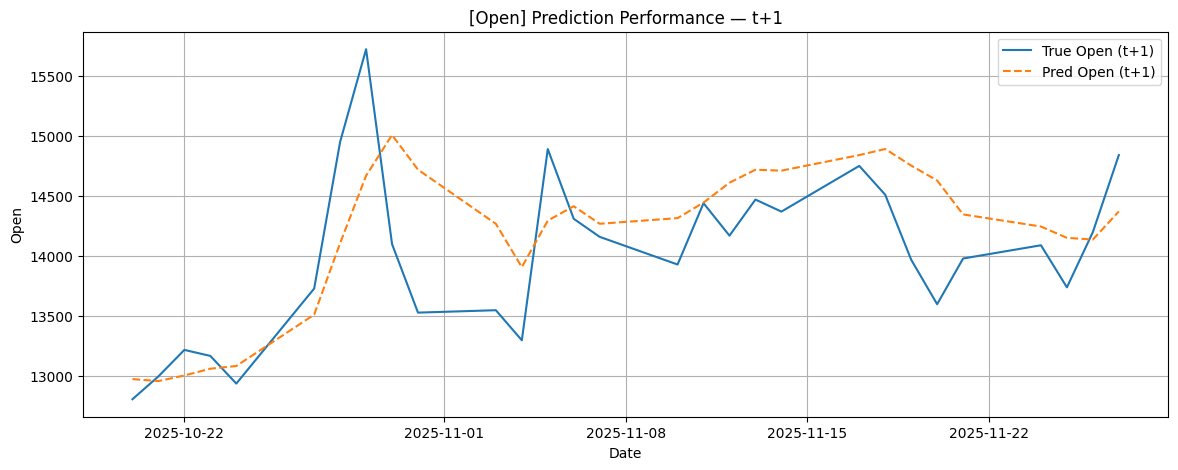

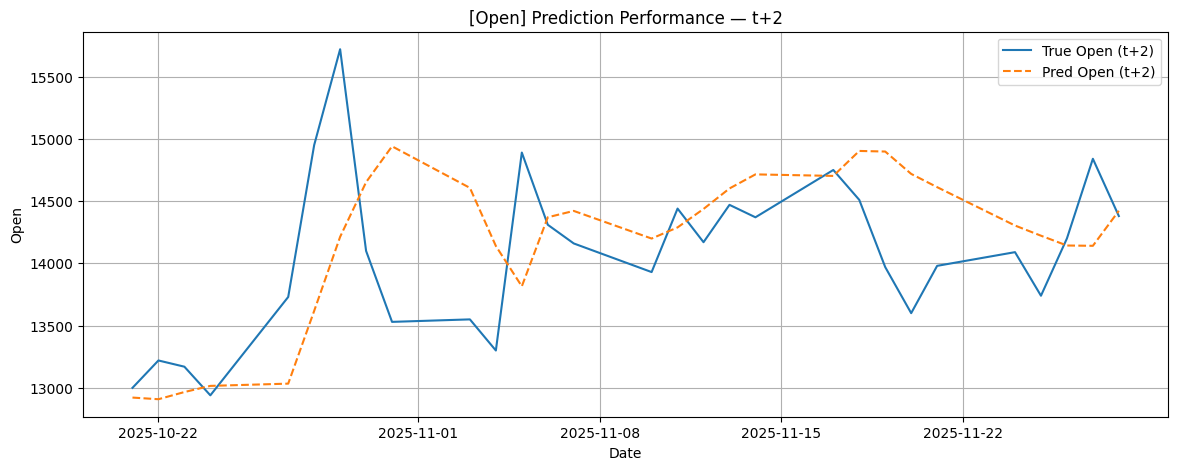

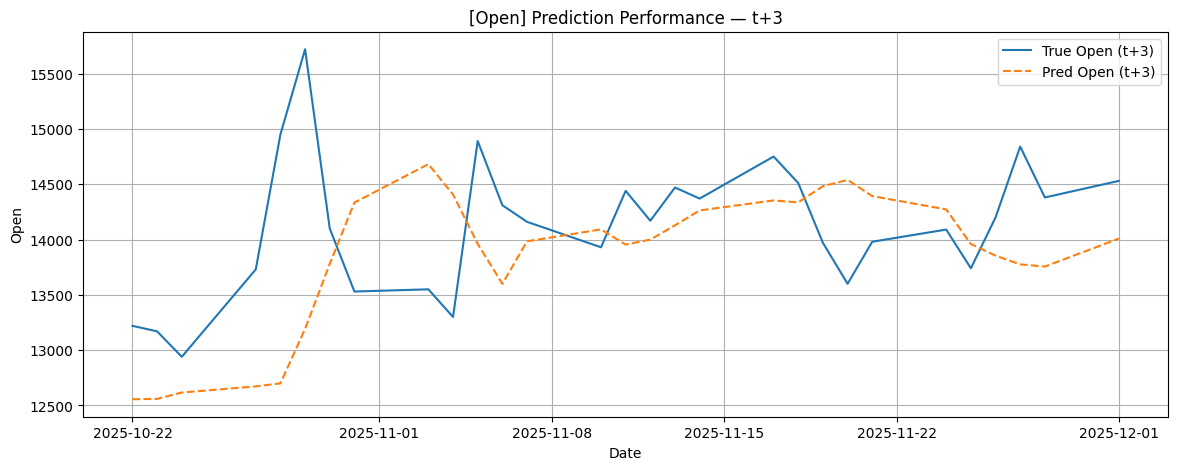

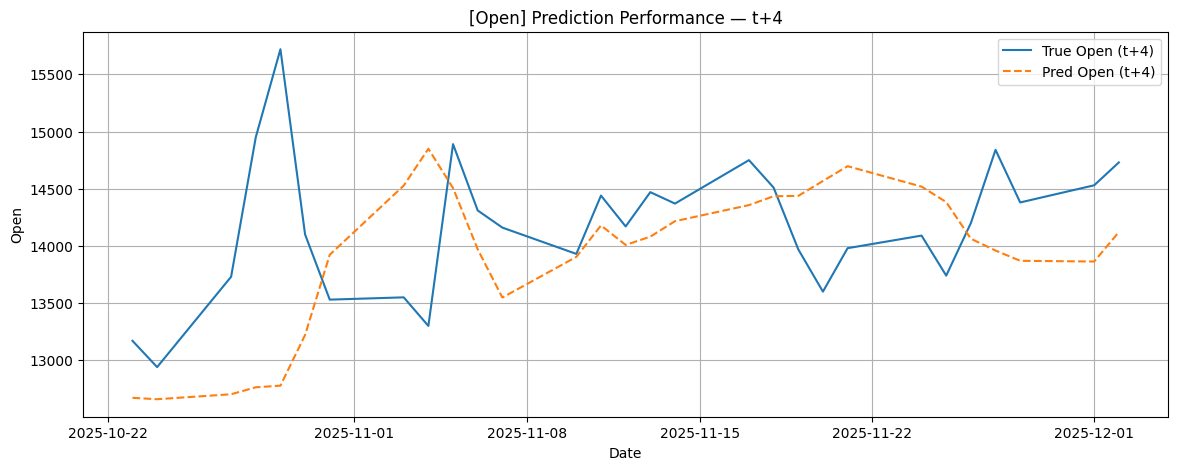

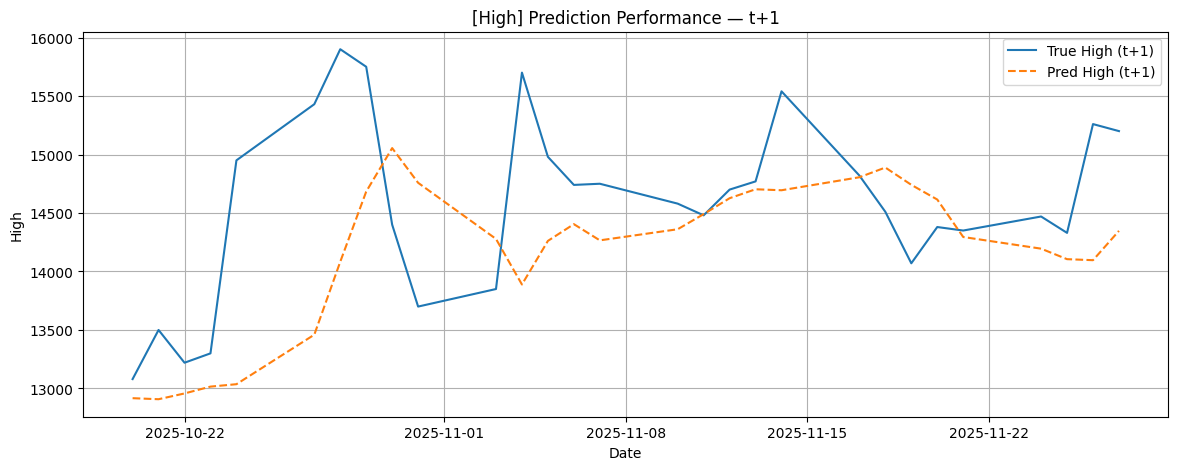

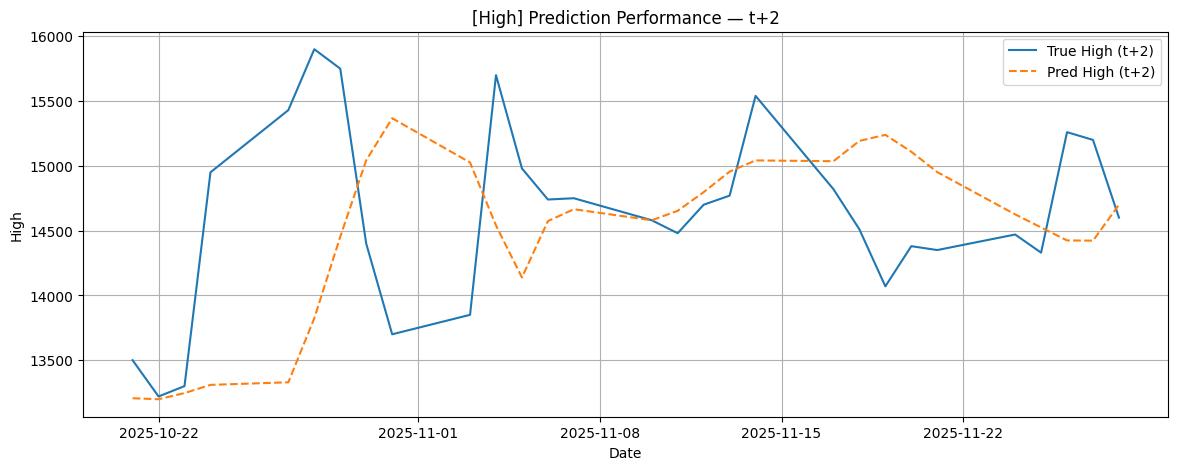

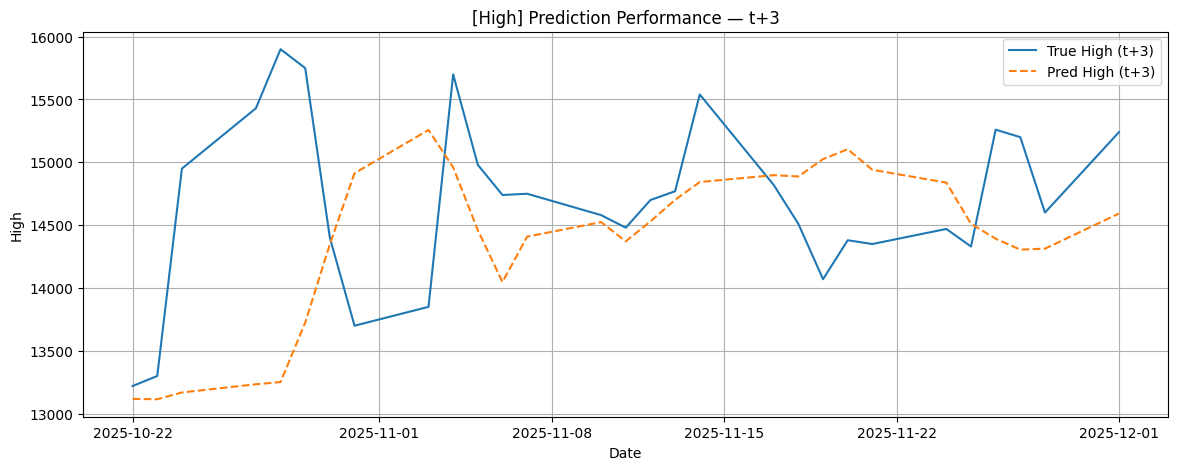

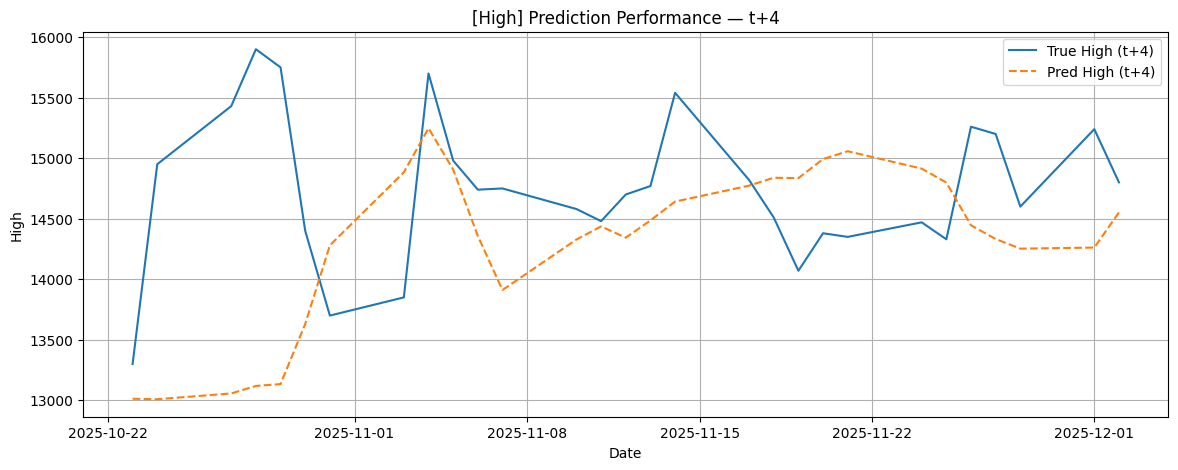

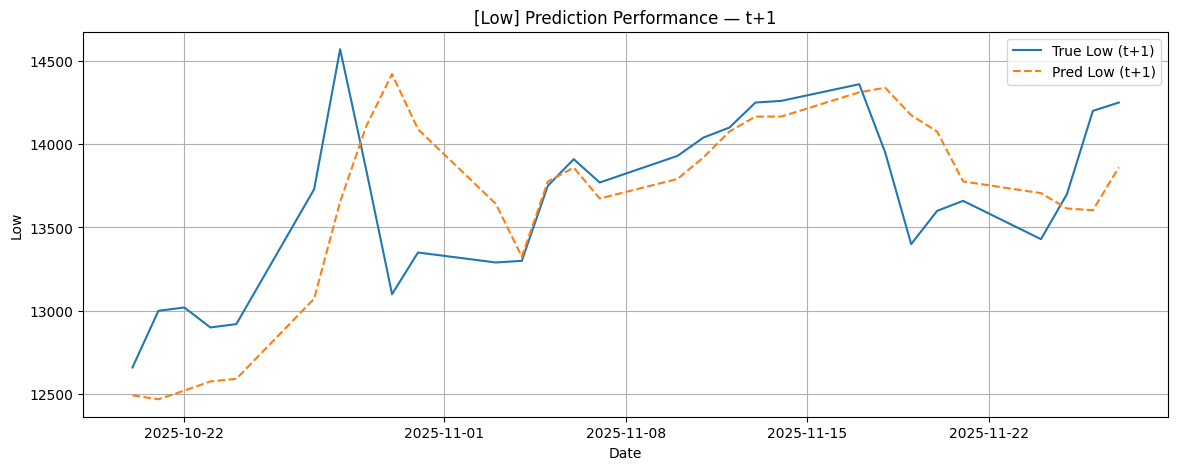

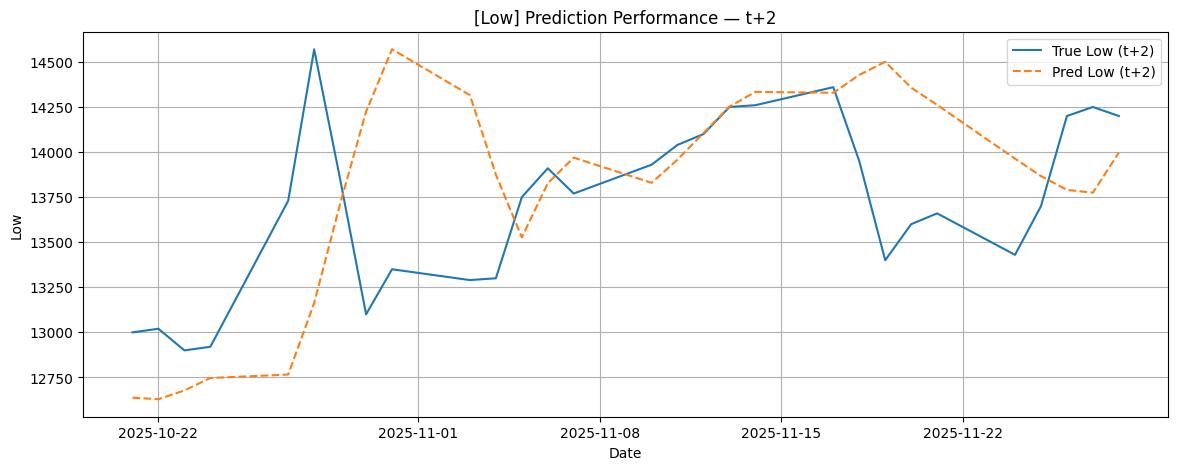

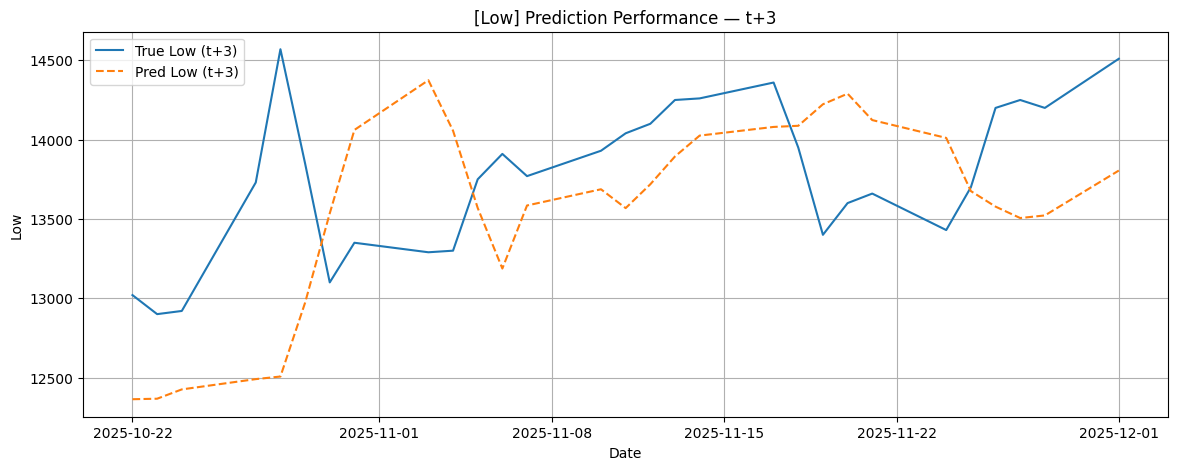

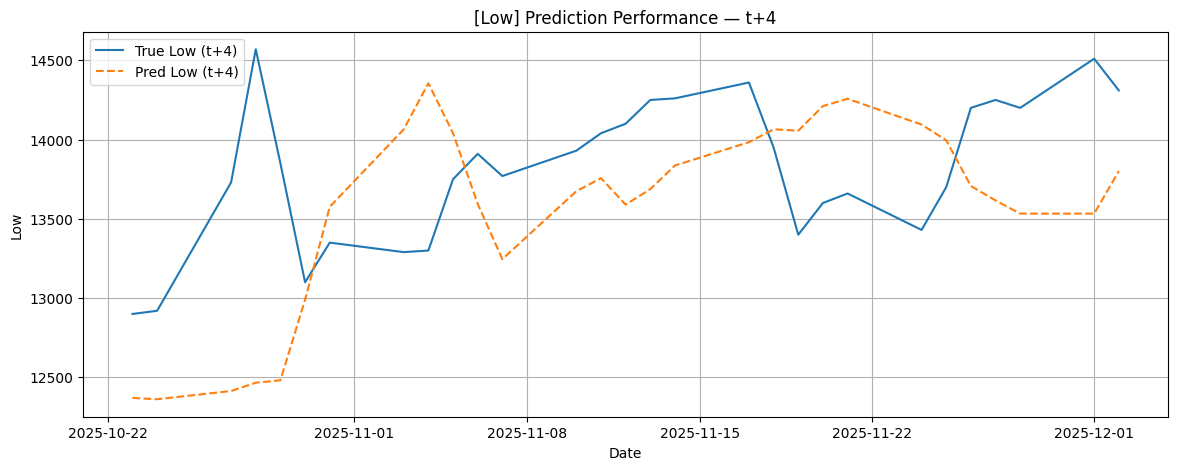

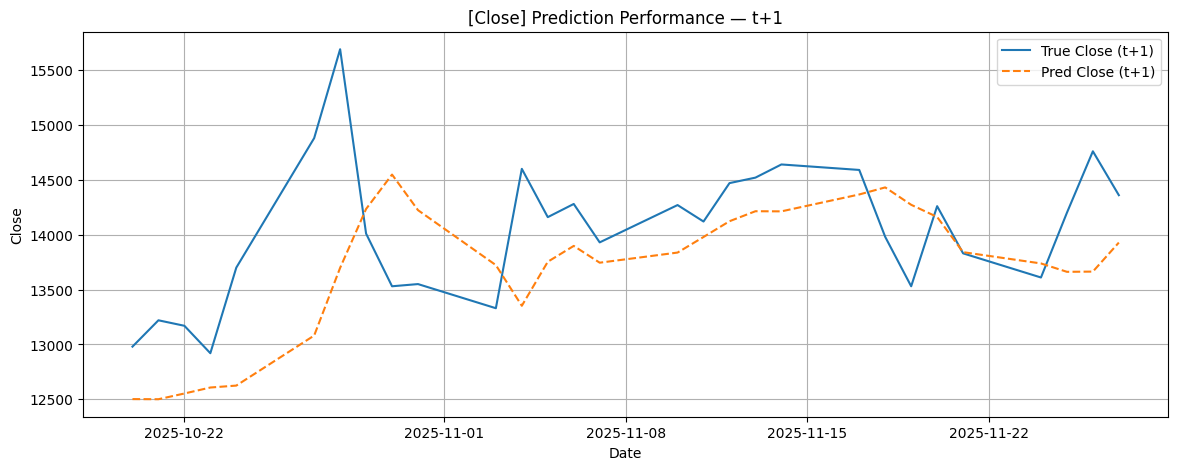

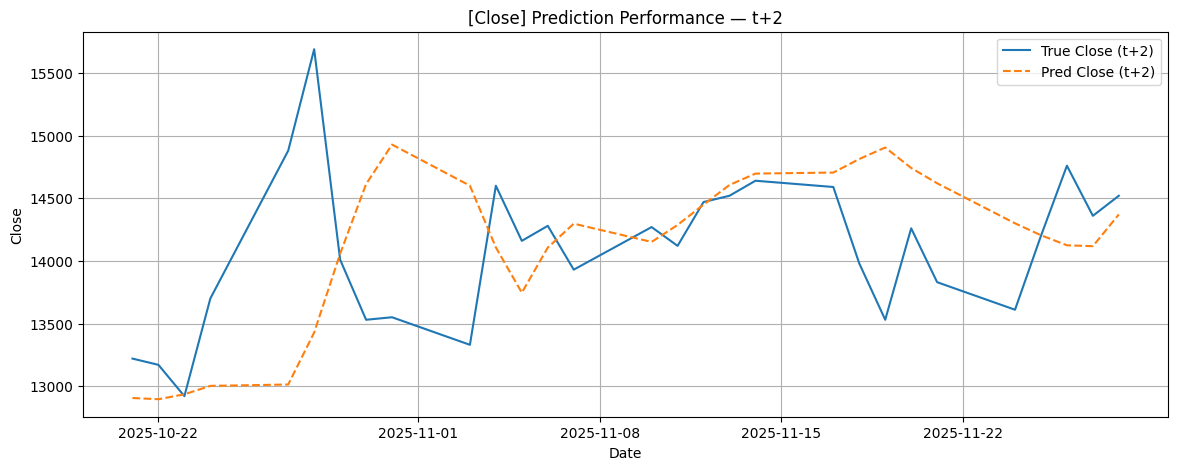

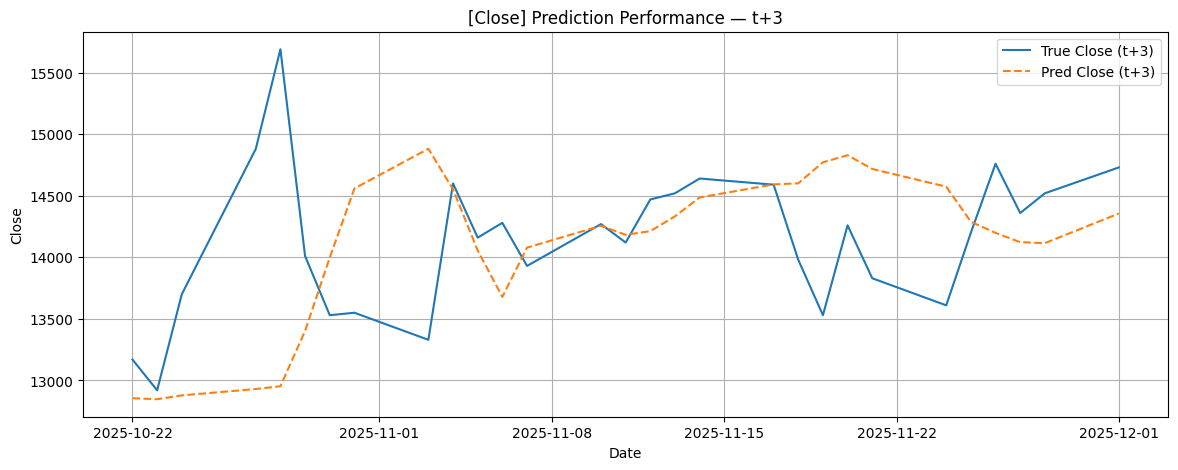

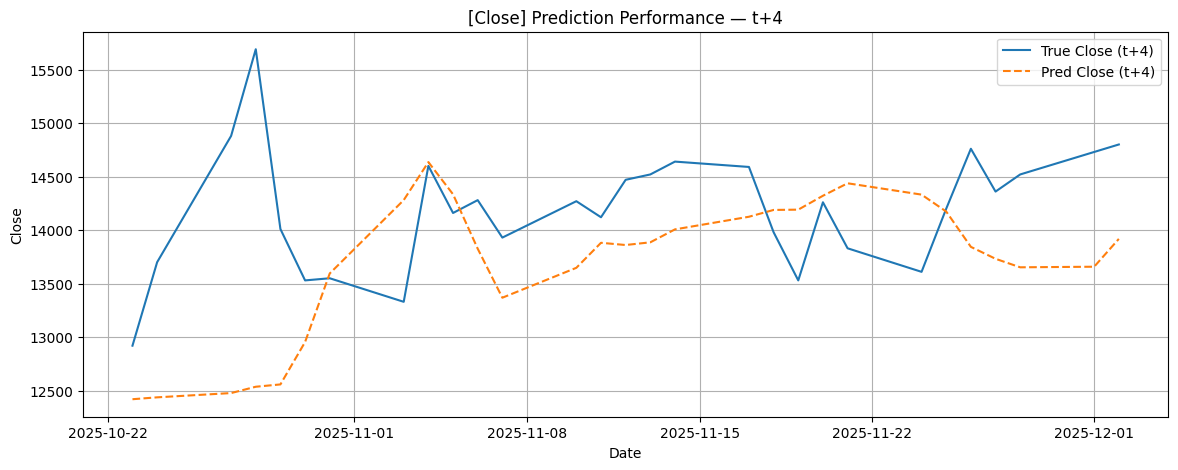

In [267]:
OHLC_NAMES = ["Open", "High", "Low", "Close"]
num_features = 4  # OHLC 4개

for feat_idx in range(num_features):          # Open/High/Low/Close
    for step in range(horizon):               # t+1 ~ t+4

        # 시계열 전체 길이만큼 초기화
        pred_series = np.full(len(full_index), np.nan)
        true_series = np.full(len(full_index), np.nan)

        # 정렬하여 날짜 위치에 매핑
        for i in range(len(pred_inv)):        # 모든 윈도우
            idx = i + window + step           # 실제 날짜 인덱스
            if idx < len(full_index):
                pred_series[idx] = pred_inv[i, step, feat_idx]
                true_series[idx] = true_inv[i, step, feat_idx]

        # ===== 그래프 =====
        plt.figure(figsize=(14,5))
        plt.plot(full_index, true_series, label=f"True {OHLC_NAMES[feat_idx]} (t+{step+1})")
        plt.plot(full_index, pred_series, '--', label=f"Pred {OHLC_NAMES[feat_idx]} (t+{step+1})")

        plt.title(f"[{OHLC_NAMES[feat_idx]}] Prediction Performance — t+{step+1}")
        plt.xlabel("Date")
        plt.ylabel(OHLC_NAMES[feat_idx])
        plt.grid()
        plt.legend()
        plt.show()


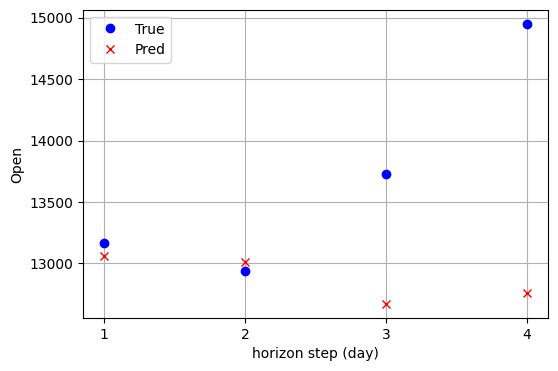

In [268]:
idx = 3 # 첫 번째 테스트 윈도우

plt.figure(figsize=(6,4))
for step in range(horizon):
    plt.plot(step+1, true_inv[idx, step, 0], 'bo')  # Open만
    plt.plot(step+1, pred_inv[idx, step, 0], 'rx')

plt.xticks([1,2,3,4])
plt.xlabel('horizon step (day)')
plt.ylabel('Open')
plt.legend(['True','Pred'])
plt.grid(True)
plt.show()
